In [1]:
# from sklearn.preprocessing import PolynomialFeatures
import numpy as np
# import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
# import randcbpside
# import randcbpside2
import games 
# import random
import math
# import pandas as pd


class Evaluation_contextual:

    def __init__(self, horizon ):

        self.horizon = horizon
        

    def get_contexts(self, context_generator):
        # outcomes = np.random.choice( 2 , p= self.distribution, size= self.horizon) 
        contexts =  [ context_generator.get_context(t)[0] for t in range(self.horizon) ]
        regions = [ context_generator.get_context(t)[1] for t in range(self.horizon) ]
        return contexts, regions

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):#jobid
        context_generator, seed = job
        np.random.seed(seed)
        alg.reset()

        self.contexts, self.regions = self.get_contexts( context_generator )
        cumRegret =  np.zeros(self.horizon, dtype =float)
        actions = np.zeros(self.horizon, dtype =float)
        alg.reset()

        for t in range(self.horizon):
            # print(t)

            context = self.contexts[t]
            region = self.regions[t]
            distribution = context_generator.get_distribution(context)
            if region == 1:
                outcome = np.random.choice( 2 , p = [0.5,0.5] )       
            else:
                outcome = np.random.choice( 2 , p = distribution )

            action = alg.get_action(t, context)
            print(t, action)
            
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )

            # regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )

            cumRegret[t] =  val
            actions[t] = action

        return  np.cumsum( cumRegret ) #, actions
    
def generate_nonuniform_vectors(size):
    while True:
        alpha = [ np.random.randint(2,10) ] * size # shape parameter
        sample = np.random.dirichlet(alpha, size=1)
        if sample[0][0] < 0.1:
            return sample[0]

class XYZContexts:
    def __init__(self, w,):
        self.d = len(w) #number of features
        self.w = w
        self.imbalance = generate_nonuniform_vectors(4)
        # print(self.imbalance)
    def get_context(self,t):

        c = np.random.choice([0,1,2,3],p=self.imbalance  ) #[1,0,0]  #generate_nonuniform_vectors()
        while True:
            if c == 0:
                context = np.random.uniform(0, 1,  self.d )
                return np.array(context).reshape(self.d,1),c
            elif c == 1:
                center = (0.1, 0.1, 0.1)
                radius = 0.025
                x = np.random.uniform(center[0]-radius, center[0]+radius)
                y = np.random.uniform(center[1]-radius, center[1]+radius)
                z = np.random.uniform(center[2]-radius, center[2]+radius)
                distance = math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                if distance <= radius:
                    context = [x,y,z]
                    return np.array(context).reshape(self.d,1),c
            elif c == 2:
                center = (0.6, 0.6, 0.9)
                radius = 0.025
                x = np.random.uniform(center[0]-radius, center[0]+radius)
                y = np.random.uniform(center[1]-radius, center[1]+radius)
                z = np.random.uniform(center[2]-radius, center[2]+radius)
                distance = math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                if distance <= radius:
                    context = [x,y,z]
                    return np.array(context).reshape(self.d,1),c
            elif c == 3:
                center = (0.3, 0.2, 0.65)
                radius = 0.1
                x = np.random.uniform(center[0]-radius, center[0]+radius)
                y = np.random.uniform(center[1]-radius, center[1]+radius)
                z = np.random.uniform(center[2]-radius, center[2]+radius)
                distance = math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                if distance <= radius:
                    context = [x,y,z]
                    return np.array(context).reshape(self.d,1),c


    def get_distribution(self,cont):
        val = self.w @ cont
        return [ val[0], 1-val[0] ]

class LinearContexts:
    def __init__(self, w, b, d, margin):
        self.d = d #number of features
        self.margin = margin #np.random.uniform(0,0.5) # decision boundary
        self.b = b #np.random.uniform(-1,1)
        self.w = w
        self.type = 'linear'
        self.d_context = 2

    # def get_context(self,t):
    #     c= np.random.choice([0,1,2],p=[0.2,0.4,0.4]  ) #[1,0,0] 
    #     if c == 0:
    #         context = np.random.uniform(0, 0.5,  self.d )
    #     elif c == 1:
    #         context = [0.5,0.5]
    #     elif c == 2:
    #         context = [0,0]

    #     return np.array(context).reshape(self.d,1)
    
    def get_context(self,t):
        c= np.random.choice([0,1,2,3],p=[1,0,0,0]  ) #[1,0,0]  #generate_nonuniform_vectors(4)
        while True:
            context = np.random.uniform(0, 1,  self.d )
            if c == 0:
                return np.array(context).reshape(self.d,1),c
            elif context[0]<0.25 and context[1]>=0.25 and c == 1:
                return np.array(context).reshape(self.d,1)
            elif context[0]>=0.25 and context[1]<0.25 and c == 2:
                return np.array(context).reshape(self.d,1)
            elif context[0]>=0.25 and context[1]>=0.25 and c == 3:
                return np.array(context).reshape(self.d,1)


    def get_distribution(self,cont):
        val = self.w @ cont
        return [ val[0], 1-val[0] ]
    

def evaluate_parallel(n_folds, horizon, algo, gam ):
    print("nbCores:", 10, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = 10) 
    
    np.random.seed(1)
    # w = np.array([1,1])
    # b = 0
    # d = 2
    # margin = 0.5
    task = Evaluation_contextual(horizon)
    jobs = []
    for _ in range(n_folds):
        w = w = np.array([0.1,0.1,0.8])#generate_nonuniform_vectors(3) 
        # jobs.append( [ LinearContexts(w, b, d, margin) , _  ] )
        jobs.append( [ XYZContexts(w ) , _  ] )

    partial_func = partial( task.eval_policy_once,  algo, gam )

    return  np.asarray(  pool.map( partial_func, jobs ) ) 

In [2]:
dim = 3
horizon = 1000
nfolds = 10
game = games.apple_tasting(False)
# alg1 = randcbpside.RandCPBside( game, dim, 1.01, 0.05, 1, 10, 10e-7)
# res1 = evaluate_parallel(nfolds, horizon, alg1, game )

# alg2 = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1, 10, 10e-7)
# res2 = evaluate_parallel(nfolds, horizon, alg2, game )
eval = Evaluation_contextual(horizon)
import PGIDSratio
alg3 = PGIDSratio.PGIDSratio(game, 2)
w = w = np.array([0.1,0.1,0.8])
# res3 = evaluate_parallel(nfolds, horizon, alg3, game )
res3 = eval.eval_policy_once(alg3, game, [ LinearContexts( np.array([0,1]),0,2,0.1 ) , 0  ])

0 1
1
1 1
1
2 1
1
3 1
1
4 1
1
5 1
1
6 1
1
7 1
1
8 1
1
9 1
1
10 1
1
11 1
1
12 1
1
13 1
1
14 1
1
15 1
1
16 1
1
17 1
1
18 1
1
19 1
1
20 1
1
21 1
1
22 1
0.8732671010947277
23 1
1
24 1
1
25 1
1
26 1
1
27 1
1
28 1
1
29 1
0.6544001807225306
30 1
1
31 1
1
32 1
1
33 1
0.7858275410685914
34 1
1
35 1
1
36 1
1
37 1
1
38 1
1
39 1
1
40 1
1
41 1
1
42 1
1
43 1
1
44 1
1
45 1
1
46 1
1
47 1
0.02002027669345218
48 0
1
49 1
1
50 1
1
51 1
1
52 1
1
53 1
1
54 1
1
55 1
1
56 1
1
57 1
1
58 1
0.35211129973575006
59 1
1
60 1
1
61 1
1
62 1
1
63 1
1
64 1
1
65 1
1
66 1
1
67 1
1
68 1
1
69 1
1
70 1
1
71 1
1
72 1
1
73 1
0
74 0
0.28661972098399435
75 0
1
76 1
0
77 0
1
78 1
1
79 1
1
80 1
1
81 1
1
82 1
1
83 1
1
84 1
1
85 1
1
86 1
1
87 1
0.20223334516307584
88 0
1
89 1
0.06927725345681048
90 0
1
91 1
1
92 1
1
93 1
1
94 1
1
95 1
1
96 1
0.08457765641696378
97 0
0.15287673189668927
98 0
1
99 1
1
100 1
1
101 1
1
102 1
0.07769764960951096
103 0
1
104 1
1
105 1
1
106 1
1
107 1
1
108 1
1
109 1
0
110 0
1
111 1
1
112 1
1
113 1
1
114

: 

res3

In [ ]:
res3

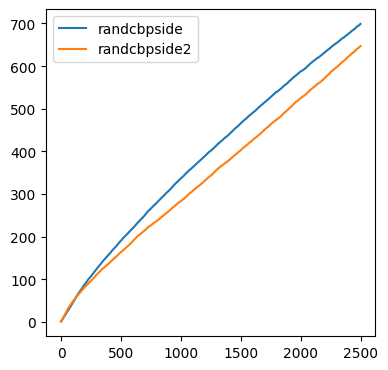

In [16]:
plt.figure(figsize=(4.25, 4.25))
plt.plot( range(horizon), np.mean(res1,0), label = 'randcbpside' )
plt.plot( range(horizon), np.mean(res2,0), label = 'randcbpside2' )
plt.legend()
# plt.savefig('./uniform_contexts.png', bbox_inches='tight', dpi=300)

In [ ]:



horizon = 1000

game = games.label_efficient()
w = np.array([1,1])
b = 0
d = 2
margin = 0.5


context_generator  = LinearContexts(w, b, d, margin)
eval = Evaluation_contextual(horizon, context_generator)


reg1,act1 = eval.eval_policy_once( alg1, game)

alg2 = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1, 10, 10e-7)
reg2,act2 = eval.eval_policy_once( alg2, game)

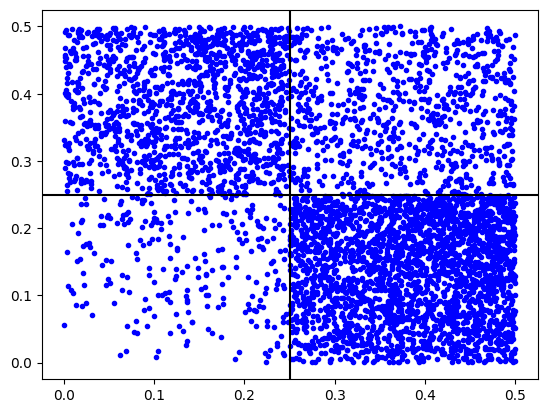

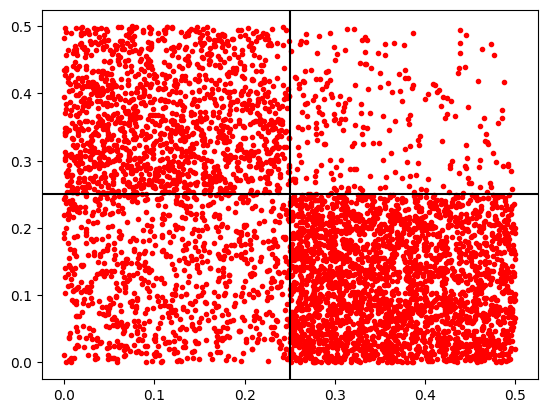

In [54]:
import numpy as np
import matplotlib.pyplot as plt

w = np.array([1,1])
b = 0
d = 2
margin = 0.5

lin = LinearContexts(w, b, d, margin)

contexts_x = []
contexts_y = []
outcomes = []
for _ in range(10000):
    cont = lin.get_context2(10)
    distribution = lin.get_distribution(cont)
    outcome = np.random.choice( 2 , p = distribution ) 
    outcomes.append(outcome)
    contexts_x.append(cont[0][0])
    contexts_y.append(cont[1][0])

plt.plot([ i if j ==0 else np.nan for i,j in zip(contexts_x,outcomes)] ,[ i if j ==0 else np.nan for i,j in zip(contexts_y,outcomes)] ,'.',color = 'blue')
plt.axvline(x=0.25, color='black')
plt.axhline(y=0.25, color='black')
plt.savefig('./outcomes0_nonuniform.png', bbox_inches='tight', dpi=300)
plt.show()

plt.plot([ i if j ==1 else np.nan for i,j in zip(contexts_x,outcomes)] ,[ i if j ==1 else np.nan for i,j in zip(contexts_y,outcomes)] ,'.' ,color = 'red')
plt.axvline(x=0.25, color='black')
plt.axhline(y=0.25, color='black')
plt.savefig('./outcomes1_nonuniform.png', bbox_inches='tight', dpi=300)
plt.show()


# contexts_x = []
# contexts_y = []
# for _ in range(500):
#     cont = lin.get_context(1,10)
#     contexts_x.append(cont[0][0])
#     contexts_y.append(cont[1][0])

# plt.plot(contexts_x,contexts_y,'.')

In [50]:






w = np.array([0,0,1])
gen = XYZContexts(w)

df = pd.DataFrame()

for _ in range(1000):
    vec = gen.get_context(10)
    p = w @ vec
    df_temp = pd.DataFrame({'x': [vec[0][0]], 'y':[vec[1][0] ], 'z': [vec[2][0] ], 'p': [ p[0] ]})
    df = pd.concat([df, df_temp])



In [51]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(df, x='x', y='y', z='z', color='p', 
                    color_continuous_scale='Viridis', range_color=[0, 1],  opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_scenes(xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1]), zaxis=dict(range=[0, 1]))
fig.update_layout(scene=dict(xaxis=dict(tickmode='linear', tick0=0, dtick=0.1),
                             yaxis=dict(tickmode='linear', tick0=0, dtick=0.1),
                             zaxis=dict(tickmode='linear', tick0=0, dtick=0.1)))

fig.update_layout(scene=dict(xaxis=dict(range=[1, 0], zeroline=False),
                             yaxis=dict(range=[1, 0], zeroline=False),
                             zaxis=dict(range=[0, 1], zeroline=False)))

fig.update_traces(marker=dict(size=3))

# Show the plot


In [2]:
import numpy as np

class Evaluation:

    def __init__(self, horizon,task):
        self.task = task
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()
        distribution, jobid, label, nfolds = job
        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0], 'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution , jobid )

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game )

        for t in range(self.horizon):
            #print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]

            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t)

            print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, None )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]
            
            result = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return  result 


eval = Evaluation(500, 'imbalanced', )
import randcbp
import games
game = games.apple_tasting(False)
alg = randcbp.RandCBP(game,1.01,1/8,10,10e-7)
job = [0.15,1-0.15], 0, None, None
eval.eval_policy_once(alg,game,job)

t 0 action 0 outcome 1
t 1 action 1 outcome 1
rhos [0.0, 0.09296744766583921, 0.18593489533167842, 0.27890234299751765, 0.37186979066335685, 0.46483723832919605, 0.5578046859950353, 0.6507721336608745, 0.7437395813267137, 0.8367070289925529]
0.18593489533167842
t 2 action 0 outcome 1
rhos [0.0, 0.11704164140024731, 0.23408328280049462, 0.35112492420074193, 0.46816656560098924, 0.5852082070012365, 0.7022498484014839, 0.8192914898017312, 0.9363331312019785, 1.0533747726022258]
0.23408328280049462
t 3 action 0 outcome 1
rhos [0.0, 0.13147582534824076, 0.2629516506964815, 0.3944274760447223, 0.525903301392963, 0.6573791267412038, 0.7888549520894446, 0.9203307774376853, 1.051806602785926, 1.1832824281341667]
0.525903301392963
t 4 action 0 outcome 1
rhos [0.0, 0.1416626270255611, 0.2833252540511222, 0.4249878810766833, 0.5666505081022444, 0.7083131351278055, 0.8499757621533666, 0.9916383891789277, 1.1333010162044888, 1.2749636432300497]
0.8499757621533666
t 5 action 0 outcome 1
rhos [0.0, 0.

array([0. , 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.

In [7]:
alpha = 1.01
K = 10
sigma = 1/8
epsilon = 10e-7

def obtain_probability(alpha, K, sigma, epsilon, t):

    U = np.sqrt( alpha  * np.log(t) ) 
    print(U)
    rhos = list( np.arange(0, U, U / (K-1) ) )
    p_m_hat =  np.array( [ 1/np.sqrt(2*np.pi )*np.exp( -(rho**2) / (2*sigma**2)  ) for rho in rhos ] )
    rhos.append(U)

    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
    Z = np.random.choice(rhos, p= p_m)
    print('rhos', rhos)
    return Z

def obtain_probability2(alpha, K, sigma, epsilon, t):

    U = np.sqrt( alpha  * np.log(t) ) 
    rhos = np.arange(0, U, U/K )
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )

    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
    print('rhos2', rhos)
        
    Z = np.random.choice(rhos, p= p_m)

    return Z

for t in range(2,10):
    print( obtain_probability(alpha, K, sigma, epsilon, t) )
    print( obtain_probability2(alpha, K, sigma, epsilon, t) )
    print()

0.8367070289925529
rhos [0.0, 0.09296744766583921, 0.18593489533167842, 0.27890234299751765, 0.37186979066335685, 0.46483723832919605, 0.5578046859950353, 0.6507721336608745, 0.7437395813267137, 0.8367070289925529]
0.0
rhos2 [0.         0.0836707  0.16734141 0.25101211 0.33468281 0.41835351
 0.50202422 0.58569492 0.66936562 0.75303633]
0.5020242173955318

1.0533747726022258
rhos [0.0, 0.11704164140024731, 0.23408328280049462, 0.35112492420074193, 0.46816656560098924, 0.5852082070012365, 0.7022498484014839, 0.8192914898017312, 0.9363331312019785, 1.0533747726022258]
0.11704164140024731
rhos2 [0.         0.10533748 0.21067495 0.31601243 0.42134991 0.52668739
 0.63202486 0.73736234 0.84269982 0.9480373 ]
0.0

1.1832824281341667
rhos [0.0, 0.13147582534824076, 0.2629516506964815, 0.3944274760447223, 0.525903301392963, 0.6573791267412038, 0.7888549520894446, 0.9203307774376853, 1.051806602785926, 1.1832824281341667]
0.0
rhos2 [0.         0.11832824 0.23665649 0.35498473 0.47331297 0.5916412

In [2]:
import numpy as np

class Evaluation:

    def __init__(self, horizon,task):
        self.task = task
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()
        distribution, jobid, label, nfolds = job
        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0], 'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution , jobid )

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game )

        for t in range(self.horizon):
            #print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]

            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t)

            print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, None )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]
            
            result = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return  result 


eval = Evaluation(500, 'imbalanced', )
import randcbp
import games
game = games.apple_tasting(False)
alg = randcbp.RandCBP(game,1.01,1/8,10,10e-7)
job = [0.15,1-0.15], 0, None, None
eval.eval_policy_once(alg,game,job)

t 0 action 0 outcome 1
t 1 action 1 outcome 1
rhos2 [0.         0.0836707  0.16734141 0.25101211 0.33468281 0.41835351
 0.50202422 0.58569492 0.66936562 0.75303633]
0.1673414057985106
t 2 action 0 outcome 1
rhos2 [0.         0.10533748 0.21067495 0.31601243 0.42134991 0.52668739
 0.63202486 0.73736234 0.84269982 0.9480373 ]
0.31601243178066774
t 3 action 0 outcome 1
rhos2 [0.         0.11832824 0.23665649 0.35498473 0.47331297 0.59164121
 0.70996946 0.8282977  0.94662594 1.06495419]
0.47331297125366667
t 4 action 0 outcome 1
rhos2 [0.         0.12749636 0.25499273 0.38248909 0.50998546 0.63748182
 0.76497819 0.89247455 1.01997091 1.14746728]
0.7649781859380299
t 5 action 0 outcome 1
rhos2 [0.         0.13452424 0.26904848 0.40357271 0.53809695 0.67262119
 0.80714543 0.94166967 1.0761939  1.21071814]
0.2690484762209469
t 6 action 0 outcome 1
rhos2 [0.         0.14019163 0.28038326 0.42057488 0.56076651 0.70095814
 0.84114977 0.98134139 1.12153302 1.26172465]
1.1215330224069884
t 7 actio

array([0. , 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.

In [3]:
1/8

0.125